# Starbucks Capstone Challenge <!-- omit in toc -->

### Introduction <!-- omit in toc -->

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example <!-- omit in toc -->

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning <!-- omit in toc -->

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice <!-- omit in toc -->

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
# for basic operation
import pandas as pd
from pandas import plotting
import numpy as np
import json
import datetime
import math
import progressbar
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from xgboost.sklearn import XGBClassifier
from keras.datasets import imdb
from keras import models, layers, optimizers, losses, metrics

# for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import shap

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
# make extra copy of the original datasets
portfolio_original = portfolio.copy()
profile_original = profile.copy()
transcript_original = transcript.copy()

## 1. Data-Preprocessing
### 1.1 Data cleaning and data exploration
#### 1.1.1 profile dataframe

In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
print('The total number of rows for profile dataset is:', len(profile))

The total number of rows for profile dataset is: 17000


In [6]:
profile[profile['age'] == 118].head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


In [7]:
print(len(profile[profile['age'] == 118]))

2175


In [8]:
print(len(profile[profile['income'].isnull()]))
print(len(profile[profile['gender'].isnull()])) #for a customer, if any of these three attributes contains missing data, the other two are missing

2175
2175


In [9]:
# Remove missing values in profile table
age_clean = profile['age'] != 118
gender_clean = profile['gender'].notnull()
income_clean = profile['income'].notnull()
profile = profile[age_clean & gender_clean & income_clean] 
print(len(profile))
print(profile.head())

14825
   gender  age                                id  became_member_on    income
1       F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
3       F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
5       M   68  e2127556f4f64592b11af22de27a7932          20180426   70000.0
8       M   65  389bc3fa690240e798340f5a15918d5c          20180209   53000.0
12      M   58  2eeac8d8feae4a8cad5a6af0499a211d          20171111   51000.0


In [10]:
# change 'id' column name to 'customer_id'
profile.rename(columns={'id':'customer_id'}, inplace=True)
profile.head()

,gender,age,customer_id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


In [11]:
# checking if there is any NULL data
profile.isnull().any().any() #False means there is no NULL data

False

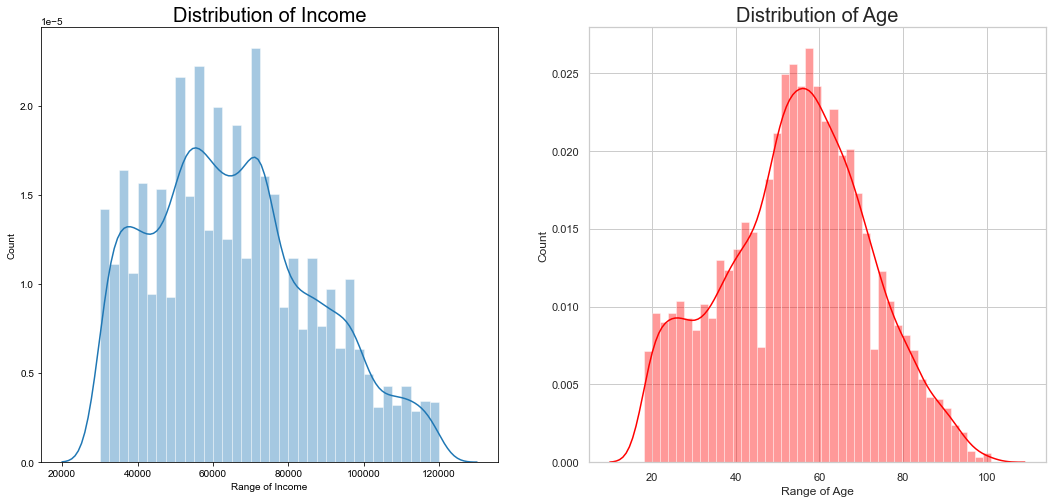

In [12]:
# visualise the distribution of income and age columns
plt.rcParams['figure.figsize'] = (18, 8)

plt.subplot(1, 2, 1)
sns.set(style = 'whitegrid')
sns.distplot(profile['income'])
plt.title('Distribution of Income', fontsize = 20)
plt.xlabel('Range of Income')
plt.ylabel('Count')


plt.subplot(1, 2, 2)
sns.set(style = 'whitegrid')
sns.distplot(profile['age'], color = 'red')
plt.title('Distribution of Age', fontsize = 20)
plt.xlabel('Range of Age')
plt.ylabel('Count')
plt.show()

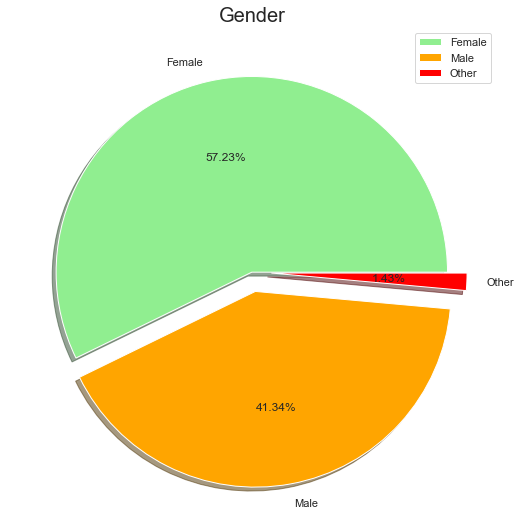

In [13]:
# visualise gender column
labels = ['Female', 'Male', 'Other']
size = profile['gender'].value_counts()
colors = ['lightgreen', 'orange', 'red']
explode = [0, 0.1, 0.1]

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Gender', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()
#plt.savefig('gender.png')

In [14]:
# extract 'year' from column 'became_member_on'
became_member_year = profile['became_member_on'].apply(lambda dt: int(str(dt)[:4]))
became_member_year.head()

1     2017
3     2017
5     2018
8     2018
12    2017
Name: became_member_on, dtype: int64

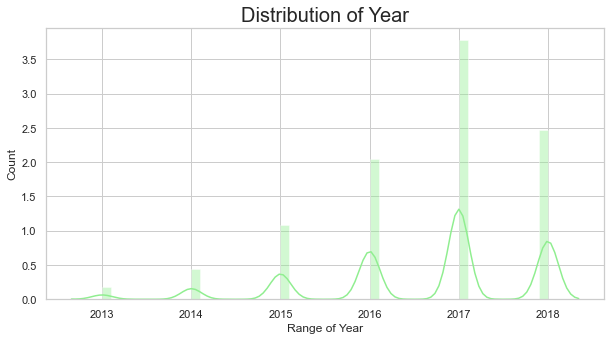

In [15]:
# visualise distribution of each year that customers became Starbucks member
plt.rcParams['figure.figsize'] = (10, 5)

sns.set(style = 'whitegrid')
sns.distplot(became_member_year, color = 'lightgreen')
plt.title('Distribution of Year', fontsize = 20)
plt.xlabel('Range of Year')
plt.ylabel('Count')
plt.show()

In [16]:
# convert the column 'became_member_on' to the 'membership_days'
profile.dtypes

gender               object
age                   int64
customer_id          object
became_member_on      int64
income              float64
dtype: object

In [17]:
profile['membership_date'] = pd.to_datetime(profile['became_member_on'].astype(str), format='%Y%m%d')

In [18]:
profile['membership_days'] = (
    profile['membership_date'].sub(pd.Timestamp.now()).dt.days
)
profile['membership_days'].head()

1    -1125
3    -1192
5     -840
8     -916
12   -1006
Name: membership_days, dtype: int64

In [19]:
profile['membership_days'] = profile['membership_days'] * (-1)

In [20]:
# drop column 'became_member_on', 'membership_date'
profile = profile.drop(columns = ['became_member_on', 'membership_date'])
profile.head()

,gender,age,customer_id,income,membership_days
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1125
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1192
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,840
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,916
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1006


#### 1.1.2 portfolio dataframe

In [21]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [22]:
# change 'id' column name to 'offer_id'
portfolio.rename(columns={'id':'offer_id'}, inplace=True)
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [23]:
print('The total number of rows for profolio dataset is:',len(portfolio))
# there's no missing data found in this table
# but we will need to perform data transformation before the data can be fed into the model (One-Hot Encoding)

The total number of rows for profolio dataset is: 10


In [24]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


#### 1.1.3 transcript dataframe

In [25]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [26]:
print('The total number of rows for transcript dataset is:', len(transcript))

The total number of rows for transcript dataset is: 306534


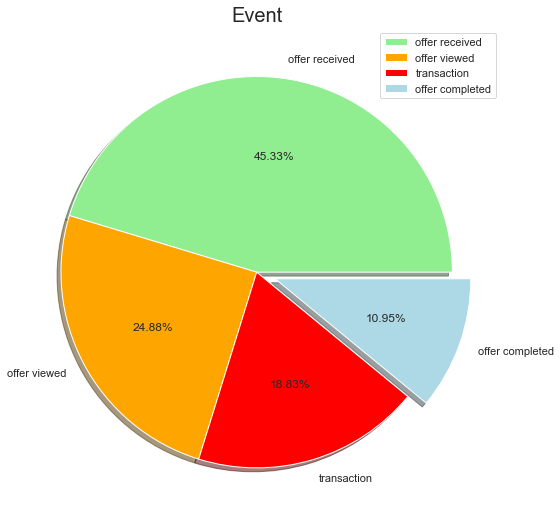

In [27]:
# visualise 'event' column
labels = ['offer received', 'offer viewed', 'transaction', 'offer completed']
size = transcript['event'].value_counts()
colors = ['lightgreen', 'orange', 'red', 'lightblue']
explode = [0, 0, 0, 0.1]

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Event', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

In [28]:
# change 'person' column name to 'customer_id'
transcript.rename(columns={'person':'customer_id'}, inplace=True)
transcript.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [29]:
# change 'time' column from hours to days
transcript['time'] = transcript['time'] / 24
transcript.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0.0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0.0


#### 1.1.4 Understand the data

In [30]:
# we have a look at the 5 rows for completed offers
# pick a random cusomer who has completed the offer and have a look at all his/her records
transcript[transcript['event'] == 'offer completed'].head()

,customer_id,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0.0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0.0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0.0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0.0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0.0


In [31]:
# we take customer_id 9fa9ae8f57894cc9a3b8a9bbe0fc1b2f as an example
transcript[transcript['customer_id'] == '9fa9ae8f57894cc9a3b8a9bbe0fc1b2f'].head()

# the first four rows show us that this customer received and viewed the offer
# then made the purchase for $34.56 and completed the offer on the same day

,customer_id,event,value,time
36,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0.00
12656,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0.00
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0.00
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0.00
27850,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 21.55},1.75


In [32]:
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [33]:
# we can take a look at thi offer by using offer_id '2906b810c7d4411798c6938adc9daaa5' in porfolio dataset
# this offer is that if a customer spends $10, he/she will get $2 reward
portfolio[portfolio['offer_id'] == '2906b810c7d4411798c6938adc9daaa5']

,reward,channels,difficulty,duration,offer_type,offer_id
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


### 1.2 Data Transformation
#### 1.2.1 Profile Dataframe

In [34]:
#One-Hot Encoding the column 'gender' (Female/Male/Other)
profile['female'] = pd.get_dummies(profile['gender'])['F']
profile['male'] = pd.get_dummies(profile['gender'])['M']
profile['other_gender'] = pd.get_dummies(profile['gender'])['O']

# drop column 'gender'
profile = profile.drop(columns = ['gender'])
profile.head()

,age,customer_id,income,membership_days,female,male,other_gender
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1125,1,0,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1192,1,0,0
5,68,e2127556f4f64592b11af22de27a7932,70000.0,840,0,1,0
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,916,0,1,0
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1006,0,1,0


Since the values for 'age' column ranges from 18 to 101, we could devide them into several age groups:

* 'age_under25' (which is not including age 25)
* 'age_25_to_35'(which is including age 25 but not including age 35)
* 'age_35_to_45'(which is including age 35 but not including age 45)
* 'age_45_to_55'(which is including age 45 but not including age 55)
* 'age_55_to_65'(which is including age 55 but not including age 65)
* 'age_65_to_75'(which is including age 65 but not including age 75)
* 'age_75_to_85'(which is including age 75 but not including age 85)
* 'age_85_to_105'(which is including age 85 but not including age 105)

In [35]:
# split age to several age groups
bins= [0,25,35,45,55,65,75,85,105]
labels = ['age_under25', 'age_25_to_35', 'age_35_to_45', 'age_45_to_55', 'age_55_to_65', 'age_65_to_75', 'age_75_to_85', 'age_85_to_105']
profile['age_group'] = pd.cut(profile['age'], bins=bins, labels=labels, right=False)
profile.head()

,age,customer_id,income,membership_days,female,male,other_gender,age_group
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1125,1,0,0,age_55_to_65
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1192,1,0,0,age_75_to_85
5,68,e2127556f4f64592b11af22de27a7932,70000.0,840,0,1,0,age_65_to_75
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,916,0,1,0,age_65_to_75
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1006,0,1,0,age_55_to_65


In [36]:
#One-Hot Encoding the column 'age_group'
profile['age_under25'] = pd.get_dummies(profile['age_group'])['age_under25']
profile['age_25_to_35'] = pd.get_dummies(profile['age_group'])['age_25_to_35']
profile['age_35_to_45'] = pd.get_dummies(profile['age_group'])['age_35_to_45']
profile['age_45_to_55'] = pd.get_dummies(profile['age_group'])['age_45_to_55']
profile['age_55_to_65'] = pd.get_dummies(profile['age_group'])['age_55_to_65']
profile['age_65_to_75'] = pd.get_dummies(profile['age_group'])['age_65_to_75']
profile['age_75_to_85'] = pd.get_dummies(profile['age_group'])['age_75_to_85']
profile['age_85_to_105'] = pd.get_dummies(profile['age_group'])['age_85_to_105']

# drop column 'age' and 'age_group'
profile = profile.drop(columns = ['age', 'age_group'])
profile.head()

,customer_id,income,membership_days,female,male,other_gender,age_under25,age_25_to_35,age_35_to_45,age_45_to_55,age_55_to_65,age_65_to_75,age_75_to_85,age_85_to_105
1,0610b486422d4921ae7d2bf64640c50b,112000.0,1125,1,0,0,0,0,0,0,1,0,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1192,1,0,0,0,0,0,0,0,0,1,0
5,e2127556f4f64592b11af22de27a7932,70000.0,840,0,1,0,0,0,0,0,0,1,0,0
8,389bc3fa690240e798340f5a15918d5c,53000.0,916,0,1,0,0,0,0,0,0,1,0,0
12,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1006,0,1,0,0,0,0,0,1,0,0,0


In [37]:
# save the cleaned profile table in a csv file
profile.to_csv('profile_clean.csv', index = False)

#### 1.2.2 Portfolio Dataframe

In [38]:
#One-Hot Encoding the column 'offer_type' (informational/discount/bogo)
portfolio['informational'] = pd.get_dummies(portfolio['offer_type'])['informational']
portfolio['discount'] = pd.get_dummies(portfolio['offer_type'])['discount']
portfolio['bogo'] = pd.get_dummies(portfolio['offer_type'])['bogo']

In [39]:
#One-Hot Encoding the column 'channels' (email/mobile/social/web)
#create the MultiLabelBinarizer and fit_trasnform the data
mlb = MultiLabelBinarizer()
dummy = mlb.fit_transform(portfolio.channels.to_numpy())

#create the dataframe with columns names
dummy_df = pd.DataFrame(dummy, portfolio.index, mlb.classes_)

dummy_df

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,0
8,1,1,1,1
9,1,1,0,1


In [40]:
portfolio['email'] = dummy_df['email']
portfolio['mobile'] = dummy_df['mobile']
portfolio['social'] = dummy_df['social']
portfolio['web'] = dummy_df['web']

# drop column 'offer_type' and 'channels'
portfolio = portfolio.drop(columns = ['offer_type', 'channels'])
portfolio.head()

,reward,difficulty,duration,offer_id,informational,discount,bogo,email,mobile,social,web
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,0,1,1,1,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,1,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,0,0,1,1,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,1,1,0,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1


In [41]:
# set column 'offer_id' to the first column

# get a list of columns
cols = list(portfolio)
# move the column 'offer_id' to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('offer_id')))
print(cols)
# use .loc to reorder
portfolio = portfolio.loc[:, cols]
portfolio.head()

['offer_id', 'reward', 'difficulty', 'duration', 'informational', 'discount', 'bogo', 'email', 'mobile', 'social', 'web']


,offer_id,reward,difficulty,duration,informational,discount,bogo,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,0,0,1,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,0,0,1,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,0,4,1,0,0,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,0,0,1,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,0,1,0,1,0,0,1


In [42]:
# remove 'email' column as the value for each cell on this column is always '1'
portfolio = portfolio.drop(columns = ['email'])
portfolio

,offer_id,reward,difficulty,duration,informational,discount,bogo,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,0,0,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,0,4,1,0,0,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,0,0,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,0,1,0,0,0,1
5,2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,0,1,0,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,0,1,0,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,0,0,3,1,0,0,1,1,0
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,0,0,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,2,10,7,0,1,0,1,0,1


In [43]:
# save the cleaned portfolio table in a csv file
portfolio.to_csv('portfolio_clean.csv', index = False)

#### 1.2.3 Transcript Dataframe

In [44]:
transcript

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0.00
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0.00
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0.00
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0.00
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0.00
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},29.75
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},29.75
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},29.75
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},29.75


In [45]:
transcript['offer_id'] = transcript['value'].apply(lambda x: list(x.values())[0] if list(x.keys())[0] in ['offer_id', 'offer id'] else None)

In [46]:
transcript['amount'] = transcript['value'].apply(lambda x: list(x.values())[0] if list(x.keys())[0] in ['amount'] else None)

In [47]:
transcript

,customer_id,event,value,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0.00,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0.00,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},29.75,None,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},29.75,None,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},29.75,None,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},29.75,None,3.53


In [48]:
transcript.amount.astype('float')
transcript

,customer_id,event,value,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0.00,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0.00,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},29.75,None,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},29.75,None,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},29.75,None,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},29.75,None,3.53


In [49]:
# drop value column
transcript = transcript.drop(columns = ['value'])

# only keep customer_ids which are in the profile df 
transcript = transcript[transcript.customer_id.isin(profile.customer_id)]

In [50]:
transcript

,customer_id,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0.00,2906b810c7d4411798c6938adc9daaa5,NaN
5,389bc3fa690240e798340f5a15918d5c,offer received,0.00,f19421c1d4aa40978ebb69ca19b0e20d,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0.00,3f207df678b143eea3cee63160fa8bed,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
...,...,...,...,...,...
306527,24f56b5e1849462093931b164eb803b5,offer completed,29.75,fafdcd668e3743c1bb461111dcafc2a4,NaN
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,29.75,None,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,29.75,None,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,29.75,None,3.61


In [51]:
# drop deplicated rows and reset index
transcript.drop_duplicates(inplace=True)

transcript.reset_index(drop=True, inplace=True)
transcript.tail()

,customer_id,event,time,offer_id,amount
272383,24f56b5e1849462093931b164eb803b5,offer completed,29.75,fafdcd668e3743c1bb461111dcafc2a4,NaN
272384,b3a1272bc9904337b331bf348c3e8c17,transaction,29.75,None,1.59
272385,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,29.75,None,9.53
272386,a00058cf10334a308c68e7631c529907,transaction,29.75,None,3.61
272387,76ddbd6576844afe811f1a3c0fbb5bec,transaction,29.75,None,3.53


In [52]:
# set column 'offer_id' to the second column

# get a list of columns
#cols_1 = list(transcript)
# move the column 'offer_id' to head of list using index, pop and insert
#cols_1.insert(1, cols_1.pop(cols_1.index('offer_id')))
#print(cols_1)
# use .loc to reorder
#transcript = transcript.loc[:, cols_1]
#transcript

In [53]:
transaction_df = transcript[transcript.event=='transaction'].copy()

transaction_df.drop(columns=['offer_id', 'event'], inplace=True)
transaction_df

,customer_id,time,amount
11027,02c083884c7d45b39cc68e1314fec56c,0.00,0.83
11030,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.00,34.56
11032,54890f68699049c2a04d415abc25e717,0.00,13.23
11040,b2f1cd155b864803ad8334cdf13c4bd2,0.00,19.51
11041,fe97aa22dd3e48c8b143116a8403dd52,0.00,18.97
...,...,...,...
272382,24f56b5e1849462093931b164eb803b5,29.75,22.64
272384,b3a1272bc9904337b331bf348c3e8c17,29.75,1.59
272385,68213b08d99a4ae1b0dcb72aebd9aa35,29.75,9.53
272386,a00058cf10334a308c68e7631c529907,29.75,3.61


In [54]:
offers_df = transcript[transcript.event!='transaction'].copy()
events = pd.get_dummies(offers_df['event'])
offers_df = pd.concat([offers_df, events], axis=1)
offers_df.drop(columns=['event', 'amount'], inplace=True)

In [55]:
offers_df.columns = offers_df.columns.str.replace(' ', '_')
offers_df

,customer_id,time,offer_id,offer_completed,offer_received,offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,e2127556f4f64592b11af22de27a7932,0.00,2906b810c7d4411798c6938adc9daaa5,0,1,0
2,389bc3fa690240e798340f5a15918d5c,0.00,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0.00,3f207df678b143eea3cee63160fa8bed,0,1,0
4,aa4862eba776480b8bb9c68455b8c2e1,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
...,...,...,...,...,...,...
272343,84fb57a7fe8045a8bf6236738ee73a0f,29.75,5a8bc65990b245e5a138643cd4eb9837,0,0,1
272350,abc4359eb34e4e2ca2349da2ddf771b6,29.75,3f207df678b143eea3cee63160fa8bed,0,0,1
272363,8dda575c2a1d44b9ac8e8b07b93d1f8e,29.75,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1
272365,8431c16f8e1d440880db371a68f82dd0,29.75,fafdcd668e3743c1bb461111dcafc2a4,1,0,0


In [56]:
# in offers dataset, there are more information we want to know about
# did any customer receive an offer more than once?
check_1 = offers_df.apply(lambda row: f"{row['customer_id']}_{row['offer_id']}" if (row['offer_received']) else np.nan, axis=1)
check_1.value_counts()

# in the first row we can see that there are 5 records of offer_id '5a8bc65990b245e5a138643cd4eb9837' received
# associated with the customer_id 'eece6a9a7bdd4ea1b0f812f34fc619d6'

6d2db3aad94648259e539920fc2cf2a6_f19421c1d4aa40978ebb69ca19b0e20d    5
eece6a9a7bdd4ea1b0f812f34fc619d6_5a8bc65990b245e5a138643cd4eb9837    5
43a50d7e5c8547a9aa1ec31291b9fc30_0b1e1539f2cc45b7b9fa7c272da2e1d7    5
23d67a23296a485781e69c109a10a1cf_5a8bc65990b245e5a138643cd4eb9837    5
2dab8c385a2440b78b432ecb72d68787_2298d6c36e964ae4a3e7e9706d1fb8c2    4
                                                                    ..
422b5109db734d52825cc7e02ba5ab7c_5a8bc65990b245e5a138643cd4eb9837    1
908e75ddf53e452d846784117066831d_3f207df678b143eea3cee63160fa8bed    1
f7662fcebd8049b280cc95b70caa1f23_9b98b8c7a33c4b65b9aebfe6a799e6d9    1
8b7f0794dd894757bb6ca592bd3fce39_3f207df678b143eea3cee63160fa8bed    1
d0de5df4a59845fc865659b10adfb80e_f19421c1d4aa40978ebb69ca19b0e20d    1
Length: 55222, dtype: int64

In [57]:
# take the first row as an example, this customer has received the same offer five times (every week)
offers_df[(offers_df['customer_id'] == 'eece6a9a7bdd4ea1b0f812f34fc619d6') 
           & (offers_df['offer_id'] == '5a8bc65990b245e5a138643cd4eb9837')
           & (offers_df['offer_received'] == 1)]

,customer_id,time,offer_id,offer_completed,offer_received,offer_viewed
7530,eece6a9a7bdd4ea1b0f812f34fc619d6,0.0,5a8bc65990b245e5a138643cd4eb9837,0,1,0
54944,eece6a9a7bdd4ea1b0f812f34fc619d6,7.0,5a8bc65990b245e5a138643cd4eb9837,0,1,0
141508,eece6a9a7bdd4ea1b0f812f34fc619d6,17.0,5a8bc65990b245e5a138643cd4eb9837,0,1,0
186752,eece6a9a7bdd4ea1b0f812f34fc619d6,21.0,5a8bc65990b245e5a138643cd4eb9837,0,1,0
225302,eece6a9a7bdd4ea1b0f812f34fc619d6,24.0,5a8bc65990b245e5a138643cd4eb9837,0,1,0


In [58]:
# in portfolio dataset, we can have a look at this offer
# it's an informational offer
portfolio[portfolio['offer_id'] == '5a8bc65990b245e5a138643cd4eb9837'] 

,offer_id,reward,difficulty,duration,informational,discount,bogo,mobile,social,web
7,5a8bc65990b245e5a138643cd4eb9837,0,0,3,1,0,0,1,1,0


In [59]:
# then we can also check if any customer received the same offer more than once at the same time
check_2 = offers_df.apply(lambda row: f"{row['customer_id']}_{row['offer_id']}_{row['time']}" if (row['offer_received']) else np.nan, axis=1)
check_2.value_counts()

# we can see from the output below: for the same time a certain customer will only receive a certain offer once

674ec949e69948f493d910ab163eb142_5a8bc65990b245e5a138643cd4eb9837_7.0     1
37952de9ff3e4da7b332185597217e93_3f207df678b143eea3cee63160fa8bed_24.0    1
b93935163cfb40399e6c1a3760b64f6d_5a8bc65990b245e5a138643cd4eb9837_14.0    1
1922e62c02ec4664979eaeb8653d6fc5_9b98b8c7a33c4b65b9aebfe6a799e6d9_21.0    1
b23f03652b9f475eada633abb8d4eb67_f19421c1d4aa40978ebb69ca19b0e20d_17.0    1
                                                                         ..
bc3abab34eb24ac9a44a6af6256dde4c_5a8bc65990b245e5a138643cd4eb9837_0.0     1
29678127a7de48cbadef66dd77771635_2906b810c7d4411798c6938adc9daaa5_21.0    1
c89988070f2a4f95b5844f2581256e56_ae264e3637204a6fb9bb56bc8210ddfd_21.0    1
cfbbb392abaf4dc184fab6525e6aedaf_5a8bc65990b245e5a138643cd4eb9837_17.0    1
adcfd62b7ca5466ea56ffa164603cdcc_5a8bc65990b245e5a138643cd4eb9837_17.0    1
Length: 66501, dtype: int64

In [60]:
# next step we can also check if any customer received any offer more than once at the same time
check_3 = offers_df.apply(lambda row: f"{row['customer_id']}_{row['time']}" if (row['offer_received']) else np.nan, axis=1)
check_3.value_counts()

# we can see from the output below: for the same time a certain customer will only receive any offer once
# this means we can merge offer_id and customer_id based on a certain time

bd215efd787d4305a006a56154fbcb67_7.0     1
e5e23fb385dc4553ada9c638e22a6d5d_0.0     1
7c6e3fb8f20a444b949c6d94ace44f02_7.0     1
6b979cb1a50745ca9b2cea296b0918c3_7.0     1
ddf366a81c574a8c9dc860c437b4e035_7.0     1
                                        ..
9cf1682aa5a640bcba316127b48d8777_24.0    1
7289d4edea3843f28c2ceeddcff360d2_7.0     1
4d116a23b9af4885834a3e717a5fa397_24.0    1
af5215439a5c4c6f9a0955b609de4851_24.0    1
86b32116a2364361a0c6fb793194887b_21.0    1
Length: 66501, dtype: int64

#### 1.2.4 Data Merge

In [61]:
# use progress bar to track the occuring time and the estimated finish time
# ref: https://towardsdatascience.com/learning-to-use-progress-bars-in-python-2dc436de81e5
    
def merge_data(profile, portfolio, offers_df, transaction_df):
    data = []
    
    # make a list of the customer_ids from offers_df
    customer_ids = offers_df['customer_id'].unique()
    
    widgets=[
        ' [', progressbar.Timer(), '] ',
        progressbar.Bar(),
        ' (', progressbar.ETA(), ') ',
    ]
    
    # loop through all customer ids in offers_df
    for ind in progressbar.progressbar(range(len(customer_ids)), widgets=widgets):
        
        cust_id = customer_ids[ind]
        
        # get customer profile from profile data
        customer = profile[profile['customer_id'] == cust_id]
        
        # get offer data associated with those customer_ids identified from offers_df
        # this will tell us the offer info for those customers 
        cust_offer_data = offers_df[offers_df['customer_id'] == cust_id]
        
        # get transactions data associated with the customer_ids identified from transactions_df
        cust_transaction_data = transaction_df[transaction_df['customer_id'] == cust_id]
        
        # get received offers data, completed offers data, viewed offers data from customer offers data above
        offer_received_data = cust_offer_data[cust_offer_data['offer_received'] == 1]
        offer_completed_data = cust_offer_data[cust_offer_data['offer_completed'] == 1]
        offer_viewed_data = cust_offer_data[cust_offer_data['offer_viewed'] == 1]
        
        rows = []
        # loop through each received offer
        for i in range(offer_received_data.shape[0]):
            
            # get the offer_id column from offer_received_data df
            offer_id = offer_received_data.iloc[i]['offer_id']
            
            # extract offer row from portfolio
            offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]
            
            # extract duration days of an offer from offer row
            duration = offer_row['duration'].values[0]
            
            # initialize start and end time of an offer
            start_time = offer_received_data.iloc[i]['time']
            end_time = start_time + duration
        
            # seggregate offers completed within end date
            off_completed_withintime = np.logical_and(
                offer_completed_data['time'] >= start_time, offer_completed_data['time'] <= end_time)
            
            # seggregate offers viewed within end date
            off_viewed_withintime = np.logical_and(
                offer_viewed_data['time'] >= start_time, offer_viewed_data['time'] <=end_time)

            # flag offer_successful to 1 if an offer is viewed and completed within the start and end time else to 0
            offer_successful = off_completed_withintime.sum() > 0 and off_viewed_withintime.sum() > 0
            
            # extract transactions occured within time
            transaction_withintime = np.logical_and(
                cust_transaction_data['time'] >= start_time, cust_transaction_data['time'] <= end_time)
        
            transaction_data = cust_transaction_data[transaction_withintime]
            
            # total amount spent by a customer from given offers
            transaction_total_amount = transaction_data['amount'].sum()
            
            row = {
                'offer_id': offer_id,
                'customer_id': cust_id,
                'time': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }
                
            row.update(offer_row.iloc[0,0:].to_dict())

            row.update(customer.iloc[0,:].to_dict())

            rows.append(row)
        
        data.extend(rows)
    
    data = pd.DataFrame(data)
    
    column_list = ['time', 'offer_id', 'customer_id', 'total_amount',
                       'offer_successful', 'difficulty', 'duration',
                       'reward', 'bogo', 'discount', 'informational', 
                       'mobile', 'social', 'web', 'income', 'membership_days']
    
    data[column_list]
    
    return data

In [62]:
merged_data = merge_data(profile, portfolio, offers_df, transaction_df)

 [Elapsed Time: 0:09:08] |##################################| (Time:  0:09:08) 


In [63]:
merged_data

,offer_id,customer_id,time,total_amount,offer_successful,reward,difficulty,duration,informational,discount,...,male,other_gender,age_under25,age_25_to_35,age_35_to_45,age_45_to_55,age_55_to_65,age_65_to_75,age_75_to_85,age_85_to_105
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,37.67,1,5,5,7,0,0,...,0,0,0,0,0,0,0,0,1,0
1,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,7.0,49.39,0,0,0,3,1,0,...,0,0,0,0,0,0,0,0,1,0
2,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,17.0,48.28,1,10,10,7,0,0,...,0,0,0,0,0,0,0,0,1,0
3,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,21.0,48.28,1,5,5,5,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,0.00,0,2,10,7,0,1,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66496,2906b810c7d4411798c6938adc9daaa5,3cc622f76e464bc1809a71e871579d6c,24.0,34.04,0,2,10,7,0,1,...,1,0,0,0,0,0,1,0,0,0
66497,5a8bc65990b245e5a138643cd4eb9837,01fe5ec668f241608eb2f7ec374cb1b7,24.0,19.92,0,0,0,3,1,0,...,1,0,0,0,1,0,0,0,0,0
66498,9b98b8c7a33c4b65b9aebfe6a799e6d9,d825b707198046e39baa4fdcfa11d621,24.0,28.42,0,5,5,7,0,0,...,1,0,0,0,0,0,1,0,0,0
66499,2298d6c36e964ae4a3e7e9706d1fb8c2,c207a8a8ef5c47ee970ca45f859e07eb,24.0,75.84,1,3,7,7,0,1,...,0,0,0,0,0,1,0,0,0,0


In [64]:
# set column 'total_amount' to the second column

# get a list of columns
cols_2 = list(merged_data)
# move the column 'total_amount' to second of list using index, pop and insert
cols_2.insert(1, cols_2.pop(cols_2.index('total_amount')))
print(cols_2)
# use .loc to reorder
merged_data = merged_data.loc[:, cols_2]

['offer_id', 'total_amount', 'customer_id', 'time', 'offer_successful', 'reward', 'difficulty', 'duration', 'informational', 'discount', 'bogo', 'mobile', 'social', 'web', 'income', 'membership_days', 'female', 'male', 'other_gender', 'age_under25', 'age_25_to_35', 'age_35_to_45', 'age_45_to_55', 'age_55_to_65', 'age_65_to_75', 'age_75_to_85', 'age_85_to_105']


In [65]:
# set column 'offer_successful' to the last column as our label

# get a list of columns
cols_3 = list(merged_data)
# move the column 'offer_successful' to tail of list using index, pop and insert
cols_3.insert(26, cols_3.pop(cols_3.index('offer_successful')))
print(cols_3)
# use .loc to reorder
merged_data = merged_data.loc[:, cols_3]
merged_data.head()

['offer_id', 'total_amount', 'customer_id', 'time', 'reward', 'difficulty', 'duration', 'informational', 'discount', 'bogo', 'mobile', 'social', 'web', 'income', 'membership_days', 'female', 'male', 'other_gender', 'age_under25', 'age_25_to_35', 'age_35_to_45', 'age_45_to_55', 'age_55_to_65', 'age_65_to_75', 'age_75_to_85', 'age_85_to_105', 'offer_successful']


,offer_id,total_amount,customer_id,time,reward,difficulty,duration,informational,discount,bogo,...,other_gender,age_under25,age_25_to_35,age_35_to_45,age_45_to_55,age_55_to_65,age_65_to_75,age_75_to_85,age_85_to_105,offer_successful
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,78afa995795e4d85b5d9ceeca43f5fef,0.0,5,5,7,0,0,1,...,0,0,0,0,0,0,0,1,0,1
1,5a8bc65990b245e5a138643cd4eb9837,49.39,78afa995795e4d85b5d9ceeca43f5fef,7.0,0,0,3,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,ae264e3637204a6fb9bb56bc8210ddfd,48.28,78afa995795e4d85b5d9ceeca43f5fef,17.0,10,10,7,0,0,1,...,0,0,0,0,0,0,0,1,0,1
3,f19421c1d4aa40978ebb69ca19b0e20d,48.28,78afa995795e4d85b5d9ceeca43f5fef,21.0,5,5,5,0,0,1,...,0,0,0,0,0,0,0,1,0,1
4,2906b810c7d4411798c6938adc9daaa5,0.00,e2127556f4f64592b11af22de27a7932,0.0,2,10,7,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [66]:
# calculate the percentage of each age group for successful offers from merged_data
age_data = []
for x in ['age_under25', 'age_25_to_35', 'age_35_to_45', 'age_45_to_55', 'age_55_to_65', 'age_65_to_75', 'age_75_to_85', 'age_85_to_105']:
    age_data.append((x, np.round(merged_data.groupby(by='offer_successful')[x].sum()[1] / merged_data.offer_successful.value_counts()[1], 2))) 

In [67]:
age_data

[('age_under25', 0.05),
 ('age_25_to_35', 0.08),
 ('age_35_to_45', 0.13),
 ('age_45_to_55', 0.21),
 ('age_55_to_65', 0.25),
 ('age_65_to_75', 0.17),
 ('age_75_to_85', 0.09),
 ('age_85_to_105', 0.04)]

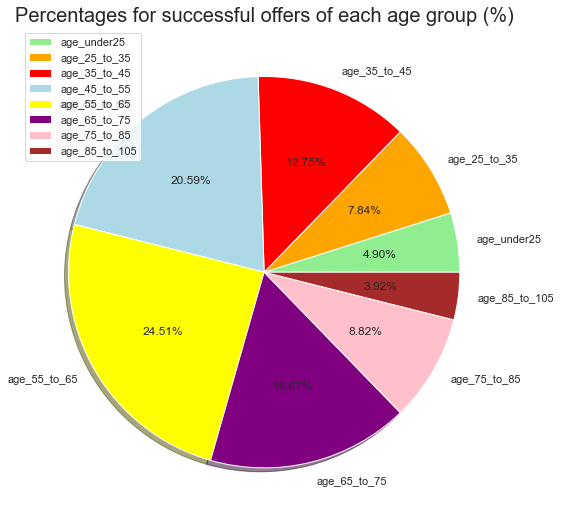

In [68]:
# visualise genders_data
labels = ['age_under25', 'age_25_to_35', 'age_35_to_45', 'age_45_to_55', 'age_55_to_65', 'age_65_to_75', 'age_75_to_85', 'age_85_to_105']
size = [5, 8, 13, 21, 25, 17, 9, 4]
colors = ['lightgreen', 'orange', 'red', 'lightblue', 'yellow', 'purple', 'pink', 'brown']
explode = [0, 0, 0, 0, 0, 0, 0, 0]

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Percentages for successful offers of each age group (%)', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

In [69]:
# calculate the percentage of each gender for successful offers from merged_data
genders_data = []
for x in ['male', 'female', 'other_gender']:
    genders_data.append((x, np.round(merged_data.groupby(by='offer_successful')[x].sum()[1] / merged_data.offer_successful.value_counts()[1], 2))) 

In [70]:
genders_data

[('male', 0.52), ('female', 0.46), ('other_gender', 0.02)]

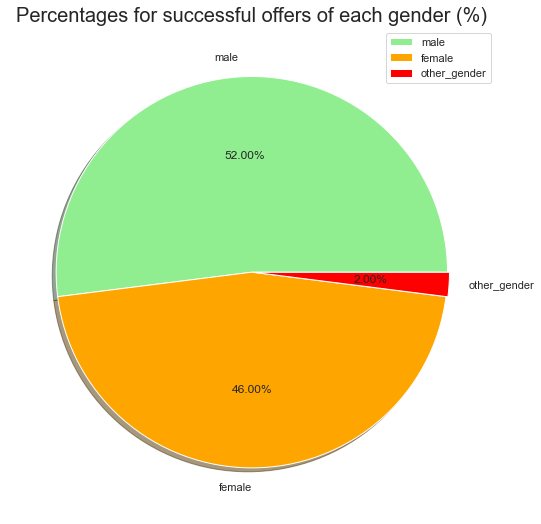

In [71]:
# visualise genders_data
labels = ['male', 'female', 'other_gender']
size = [52, 46, 2]
colors = ['lightgreen', 'orange', 'red']
explode = [0, 0, 0.01]

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Percentages for successful offers of each gender (%)', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

Previously we know that over half of the memberships are females.

However, from the figure above we can see that over half of the successful offers were associated with males.

#### 1.2.5 Data Normalisation 

In [72]:
merged_data.head()

,offer_id,total_amount,customer_id,time,reward,difficulty,duration,informational,discount,bogo,...,other_gender,age_under25,age_25_to_35,age_35_to_45,age_45_to_55,age_55_to_65,age_65_to_75,age_75_to_85,age_85_to_105,offer_successful
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,78afa995795e4d85b5d9ceeca43f5fef,0.0,5,5,7,0,0,1,...,0,0,0,0,0,0,0,1,0,1
1,5a8bc65990b245e5a138643cd4eb9837,49.39,78afa995795e4d85b5d9ceeca43f5fef,7.0,0,0,3,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,ae264e3637204a6fb9bb56bc8210ddfd,48.28,78afa995795e4d85b5d9ceeca43f5fef,17.0,10,10,7,0,0,1,...,0,0,0,0,0,0,0,1,0,1
3,f19421c1d4aa40978ebb69ca19b0e20d,48.28,78afa995795e4d85b5d9ceeca43f5fef,21.0,5,5,5,0,0,1,...,0,0,0,0,0,0,0,1,0,1
4,2906b810c7d4411798c6938adc9daaa5,0.00,e2127556f4f64592b11af22de27a7932,0.0,2,10,7,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [73]:
# first we need to drop column 'customer_id' since we don't focus on a specific customer
# we also need to drop column 'informational' as the difficulty for this type of offer is zero.
# we have already dropped column 'email' as all the offers were sent out via emails
merged_data_new = merged_data.drop(columns=['customer_id', 'time', 'informational'])
merged_data_new.head()

,offer_id,total_amount,reward,difficulty,duration,discount,bogo,mobile,social,web,...,other_gender,age_under25,age_25_to_35,age_35_to_45,age_45_to_55,age_55_to_65,age_65_to_75,age_75_to_85,age_85_to_105,offer_successful
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,5,5,7,0,1,1,0,1,...,0,0,0,0,0,0,0,1,0,1
1,5a8bc65990b245e5a138643cd4eb9837,49.39,0,0,3,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
2,ae264e3637204a6fb9bb56bc8210ddfd,48.28,10,10,7,0,1,1,1,0,...,0,0,0,0,0,0,0,1,0,1
3,f19421c1d4aa40978ebb69ca19b0e20d,48.28,5,5,5,0,1,1,1,1,...,0,0,0,0,0,0,0,1,0,1
4,2906b810c7d4411798c6938adc9daaa5,0.00,2,10,7,1,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0


In [74]:
# remove any duplicated rows and reset index
merged_data_new.drop_duplicates(inplace=True)
merged_data_new.reset_index(drop=True, inplace=True)
merged_data_new.head()

,offer_id,total_amount,reward,difficulty,duration,discount,bogo,mobile,social,web,...,other_gender,age_under25,age_25_to_35,age_35_to_45,age_45_to_55,age_55_to_65,age_65_to_75,age_75_to_85,age_85_to_105,offer_successful
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,5,5,7,0,1,1,0,1,...,0,0,0,0,0,0,0,1,0,1
1,5a8bc65990b245e5a138643cd4eb9837,49.39,0,0,3,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
2,ae264e3637204a6fb9bb56bc8210ddfd,48.28,10,10,7,0,1,1,1,0,...,0,0,0,0,0,0,0,1,0,1
3,f19421c1d4aa40978ebb69ca19b0e20d,48.28,5,5,5,0,1,1,1,1,...,0,0,0,0,0,0,0,1,0,1
4,2906b810c7d4411798c6938adc9daaa5,0.00,2,10,7,1,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0


In [75]:
print('The total number of rows before removing duplicates is:', len(merged_data))
print('The total number of rows after removing duplicates is:', len(merged_data_new))

The total number of rows before removing duplicates is: 66501
The total number of rows after removing duplicates is: 65234


In [76]:
#merged_data_new.to_csv('merged_data.csv', index=False)

In [77]:
# to avoid imblanced values in the dataset, we perform normalisation except for column 'offer_successful'
# we use MinMaxScaler()
# ref: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
# https://stats.stackexchange.com/questions/59392/should-you-ever-standardise-binary-variables

cols_norm = ['total_amount', 'reward', 'difficulty', 'duration', 'income', 'membership_days']

for col in cols_norm:
    scaler = MinMaxScaler()
    merged_data_new[col] = scaler.fit_transform(merged_data_new.loc[:, [col]])

In [78]:
# reset 'offer_id' to index
merged_data_new = merged_data_new.set_index('offer_id')
merged_data_new

,total_amount,reward,difficulty,duration,discount,bogo,mobile,social,web,income,...,other_gender,age_under25,age_25_to_35,age_35_to_45,age_45_to_55,age_55_to_65,age_65_to_75,age_75_to_85,age_85_to_105,offer_successful
offer_id,,,,,,,,,,,,,,,,,,,,,
9b98b8c7a33c4b65b9aebfe6a799e6d9,0.031366,0.5,0.25,0.571429,0,1,1,0,1,0.777778,...,0,0,0,0,0,0,0,1,0,1
5a8bc65990b245e5a138643cd4eb9837,0.041124,0.0,0.00,0.000000,0,0,1,1,0,0.777778,...,0,0,0,0,0,0,0,1,0,0
ae264e3637204a6fb9bb56bc8210ddfd,0.040200,1.0,0.50,0.571429,0,1,1,1,0,0.777778,...,0,0,0,0,0,0,0,1,0,1
f19421c1d4aa40978ebb69ca19b0e20d,0.040200,0.5,0.25,0.285714,0,1,1,1,1,0.777778,...,0,0,0,0,0,0,0,1,0,1
2906b810c7d4411798c6938adc9daaa5,0.000000,0.2,0.50,0.571429,1,0,1,0,1,0.444444,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2906b810c7d4411798c6938adc9daaa5,0.028343,0.2,0.50,0.571429,1,0,1,0,1,0.155556,...,0,0,0,0,0,1,0,0,0,0
5a8bc65990b245e5a138643cd4eb9837,0.016586,0.0,0.00,0.000000,0,0,1,1,0,0.377778,...,0,0,0,1,0,0,0,0,0,0
9b98b8c7a33c4b65b9aebfe6a799e6d9,0.023664,0.5,0.25,0.571429,0,1,1,0,1,0.477778,...,0,0,0,0,0,1,0,0,0,0


In [79]:
# remove the extra row
merged_data_new.index.name=None

In [80]:
merged_data_new.head()

,total_amount,reward,difficulty,duration,discount,bogo,mobile,social,web,income,...,other_gender,age_under25,age_25_to_35,age_35_to_45,age_45_to_55,age_55_to_65,age_65_to_75,age_75_to_85,age_85_to_105,offer_successful
9b98b8c7a33c4b65b9aebfe6a799e6d9,0.031366,0.5,0.25,0.571429,0,1,1,0,1,0.777778,...,0,0,0,0,0,0,0,1,0,1
5a8bc65990b245e5a138643cd4eb9837,0.041124,0.0,0.00,0.000000,0,0,1,1,0,0.777778,...,0,0,0,0,0,0,0,1,0,0
ae264e3637204a6fb9bb56bc8210ddfd,0.040200,1.0,0.50,0.571429,0,1,1,1,0,0.777778,...,0,0,0,0,0,0,0,1,0,1
f19421c1d4aa40978ebb69ca19b0e20d,0.040200,0.5,0.25,0.285714,0,1,1,1,1,0.777778,...,0,0,0,0,0,0,0,1,0,1
2906b810c7d4411798c6938adc9daaa5,0.000000,0.2,0.50,0.571429,1,0,1,0,1,0.444444,...,0,0,0,0,0,0,1,0,0,0


In [81]:
#merged_data_new.to_csv('merged_data_norm.csv', index=False)

In [82]:
# only keep features 
merged_data_feature = merged_data_new.drop(columns=['offer_successful'])

In [83]:
#get correlation coefficients
corr_df = merged_data_feature.corr()
corr_df.head()

,total_amount,reward,difficulty,duration,discount,bogo,mobile,social,web,income,...,male,other_gender,age_under25,age_25_to_35,age_35_to_45,age_45_to_55,age_55_to_65,age_65_to_75,age_75_to_85,age_85_to_105
total_amount,1.000000,0.040730,0.115549,0.159712,0.119486,-0.013772,-0.035777,0.038730,0.048445,0.185570,...,-0.094399,0.005555,-0.037378,-0.044832,-0.011964,-0.002996,0.027685,0.022982,0.019751,0.007762
reward,0.040730,1.000000,0.462551,0.156444,-0.292244,0.792147,-0.077509,0.287551,-0.124601,0.001960,...,0.001282,-0.004479,0.000277,0.002134,0.002196,0.000729,0.000863,-0.000048,-0.007159,-0.000482
difficulty,0.115549,0.462551,1.000000,0.807529,0.596641,-0.033615,-0.742831,-0.156511,0.241473,0.000750,...,0.001222,-0.001855,-0.001449,0.002852,-0.000973,-0.002219,0.007476,-0.001406,-0.004740,-0.003130
duration,0.159712,0.156444,0.807529,1.000000,0.740824,-0.189074,-0.530148,-0.185117,0.338772,-0.000178,...,0.002818,0.000450,-0.005767,0.005531,-0.000191,-0.004833,0.008884,0.000755,-0.005170,-0.004408
discount,0.119486,-0.292244,0.596641,0.740824,1.000000,-0.670225,-0.408544,-0.165578,0.409725,0.000123,...,0.003009,-0.000191,0.001361,0.002733,-0.001513,-0.007270,0.007008,0.000768,-0.001179,-0.003194


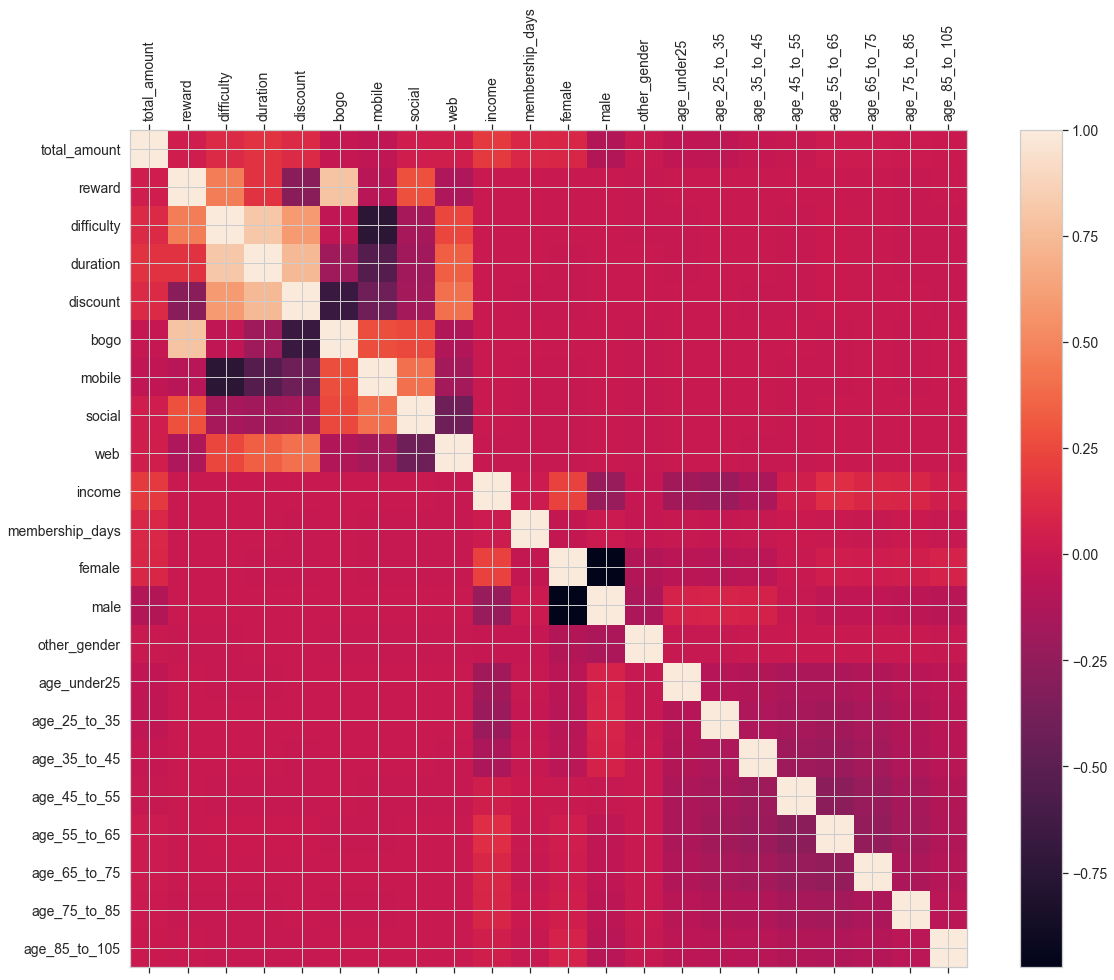

In [84]:
# plot the correlation figure
#adjust the plot
f = plt.figure(figsize=(19, 15))
plt.matshow(merged_data_feature.corr(), fignum=f.number)
plt.xticks(range(merged_data_feature.shape[1]), merged_data_feature.columns, fontsize=14, rotation=90)
plt.yticks(range(merged_data_feature.shape[1]), merged_data_feature.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16);
#plt.savefig('Correlation Matrixl.png')

## 2. Build Models
* Logistic Regression (baseline)
* XGBoost
* Neural Networks

Before building models, the dataset needs to be split into training set, testing set and validation set.

In [85]:
# split dataset into training set/testing set

def train_test_split(df, train_frac= 0.7, seed=1):
    '''Shuffle the data and randomly split into train and test sets;
       separate the class labels (the column in merged_data_new) from the features.
       :param df: Dataframe of all credit card transaction data
       :param train_frac: The decimal fraction of data that should be training data
       :param seed: Random seed for shuffling and reproducibility, default = 1
       :return: Two tuples (in order): (train_features, train_labels), (test_features, test_labels)
       '''
    
    # shuffle and split the data
    #https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html
    np.random.seed(seed) #from the function input, seed = 1, this is for the output consistency
    df_np = df.to_numpy()
    np.random.shuffle(df_np) #perform shuffle
    
    #define training data size
    train_size = int(train_frac * df_np.shape[0])
    x_train = df_np[:train_size, :-1]
    y_train = df_np[:train_size,-1] #only keep the last label column
    
    # define testing set
    x_test = df_np[train_size:, :-1]
    y_test = df_np[train_size:, -1]
    
    return (x_train, y_train), (x_test, y_test)

In [86]:
# shuffle the data and split it into training and testing data with 7:3
(x_train, y_train), (x_test, y_test) = train_test_split(merged_data_new, train_frac=0.7)

In [87]:
print('The total number of rows for training set is:', len(x_train))
print('The total number of rows for testing set is:', len(x_test))

The total number of rows for training set is: 45663
The total number of rows for testing set is: 19571


In [88]:
# convert array to df type
x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)
x_test = pd.DataFrame(x_test)
y_test = pd.DataFrame(y_test)

In [89]:
columns_name = merged_data_new.columns[:-1]
x_train.columns = columns_name
x_test.columns = columns_name

In [90]:
x_train.head()

,total_amount,reward,difficulty,duration,discount,bogo,mobile,social,web,income,...,male,other_gender,age_under25,age_25_to_35,age_35_to_45,age_45_to_55,age_55_to_65,age_65_to_75,age_75_to_85,age_85_to_105
0,0.006311,0.2,0.50,1.000000,1.0,0.0,1.0,1.0,1.0,0.355556,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.015595,0.2,0.50,1.000000,1.0,0.0,1.0,1.0,1.0,0.977778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.000000,0.0,0.00,0.142857,0.0,0.0,1.0,0.0,1.0,0.033333,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.014363,1.0,0.50,0.571429,0.0,1.0,1.0,1.0,0.0,0.400000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.021532,0.3,0.35,0.571429,1.0,0.0,1.0,1.0,1.0,0.766667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [91]:
print('Data shape (rows, cols): ', x_train.shape)

Data shape (rows, cols):  (45663, 22)


As decided in the proposal, we will use confusion matrix along with the metrics below to evaluate each model and lofistic regression model will be the baseline.

tp - True Positive

tn - True Negative

fp - False Positive

fn - False Negative

\begin{equation*}
Accuracy = \frac{tp + tn}{tp + tn + fp + fn}
\end{equation*}

\begin{equation*}
Recall = \frac{tp}{tp + fn}
\end{equation*}

\begin{equation*}
Precision = \frac{tp}{tp + fp}
\end{equation*}

\begin{equation*}
F2-score = (1 + 2^2) * \frac{Precision * Recall}{2^2 * Precision + Recall}
\end{equation*}

In [92]:
# code to evaluate the model on test data
# returns a variety of model metrics mentioned above

def evaluate(y_pred, y_test, verbose=True):
    """
    Evaluate a model on a test set given the predicted labels.  
    Return binary classification metrics.
    :param y_pred: Predicted labels on test data
    :param y_test: Class labels for test data
    :param name: Name of the model
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    # get the confusion matrix
    cm =  confusion_matrix(y_pred, y_test)

    # define true negative, false positive, false negative, true positive
    tn = cm[0][0]
    fn = cm[0][1]
    fp = cm[1][0]
    tp = cm[1][1]
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    f2_score = (5 * precision * recall) / (4 * precision + recall)
    
    # printing a table of metrics
    if verbose:
        print("Confusion matrix: \n", cm)
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('F2 score:', f2_score))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F2 score:': f2_score}


### 2.1 Logistic Regression (baseline)

In [117]:
logistic_regression = LogisticRegression()
logistic_regression.fit(x_train, y_train)
y_pred_logistic = logistic_regression.predict(x_test)

In [118]:
y_pred_logistic

array([1., 0., 0., ..., 1., 0., 0.])

In [119]:
evaluate(y_pred_logistic, y_test)

Confusion matrix: 
 [[9010 1725]
 [1138 7698]]
Accuracy:   0.854

Recall:     0.817
Precision:  0.871
F2 score:   0.827



{'TP': 7698,
 'FP': 1138,
 'FN': 1725,
 'TN': 9010,
 'Accuracy': 0.8537121250830311,
 'Precision': 0.8712086917157085,
 'Recall': 0.8169372811206622,
 'F2 score:': 0.827243810178817}

In [120]:
#Visualizing and interpreting model results:
#SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. 
#It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions see the following link:
#ref: https://github.com/slundberg/shap
# load JS visualization code to notebook
shap.initjs()

In [121]:
# use SHAP to explain the model results
# we can plot the SHAP values of every feature for every sample to have a look which feature is the most important one
# the plot below sorts features by the sum of SHAP value magnitudes over all samples, 
# and uses SHAP values to show the distribution of the impacts each feature has on the model output.
# ref: https://slundberg.github.io/shap/notebooks/linear_explainer/Sentiment%20Analysis%20with%20Logistic%20Regression.html
logistic_explainer = shap.LinearExplainer(logistic_regression, x_train, feature_dependence="independent")
shap_values_1 = logistic_explainer.shap_values(x_train)

Note that higher means more likely to be '0', so in the plots below the "blue" features are actually helping raise the chance of an successful offer (a value of '1'), while the negative features are lowering the chance.

In [124]:
# visualize the first prediction's explanation
shap.force_plot(logistic_explainer.expected_value, shap_values_1[0,:], x_train.iloc[0,:])

In [125]:
# visualize the second prediction's explanation
shap.force_plot(logistic_explainer.expected_value, shap_values_1[1,:], x_train.iloc[1,:])

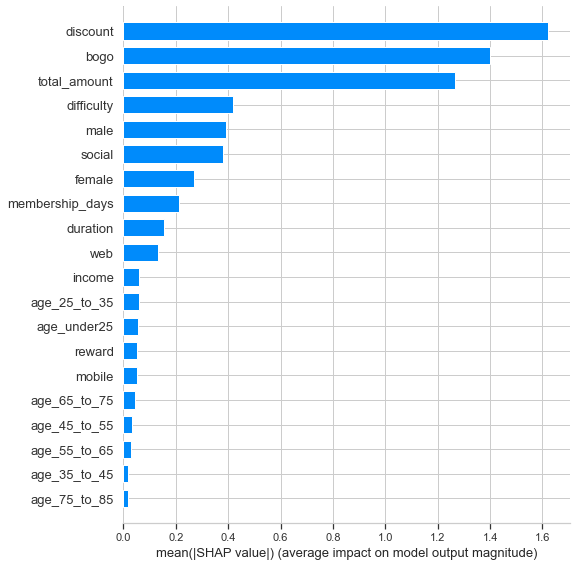

In [126]:
# plot a bar chart to list which features are most important for the model
shap.summary_plot(shap_values_1, x_train, plot_type="bar")

### 2.2 XGBoost

We initialize an instance of the XGBClassifier class. We can select the value of Lambda and Gamma, as well as the number of estimators and maximum tree depth.

In [127]:
# ref: https://xgboost.readthedocs.io/en/latest/parameter.html
xgb = XGBClassifier(random_state=42,
                    n_estimators=100,
                    reg_lambda=1, # default
                    gamma=0, # default
                    max_depth=3)

In [128]:
# fit the training set to the model
model = xgb.fit(x_train, y_train)

As we can see from the table above, 'total_amount', 'reward' and 'web' have the top three largest values which means they are the most important features in terms of determing if the offer is successful or not.

In [129]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
mybooster = model.get_booster()    
model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

# Shap explainer initilization
shap_ex = shap.TreeExplainer(mybooster)

In [130]:
shap_values_2 = shap_ex.shap_values(x_train)

In [131]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(shap_ex.expected_value, shap_values_2[0,:], x_train.iloc[0,:])

In [132]:
# visualize the second prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(shap_ex.expected_value, shap_values_2[1,:], x_train.iloc[1,:])

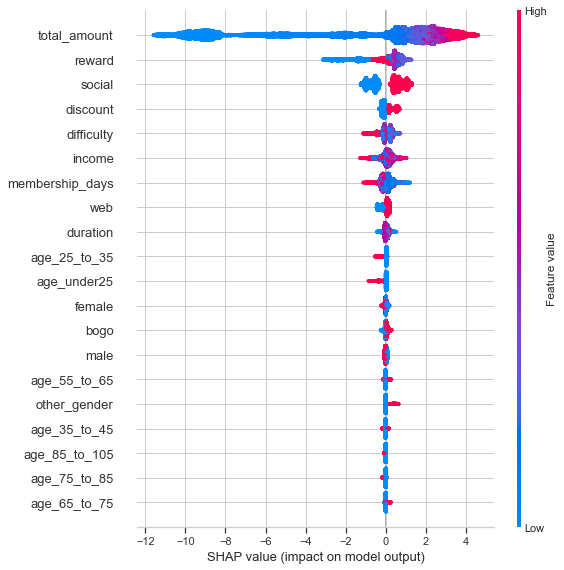

In [133]:
# summarize the effects of all the features
shap.summary_plot(shap_values_2, x_train)

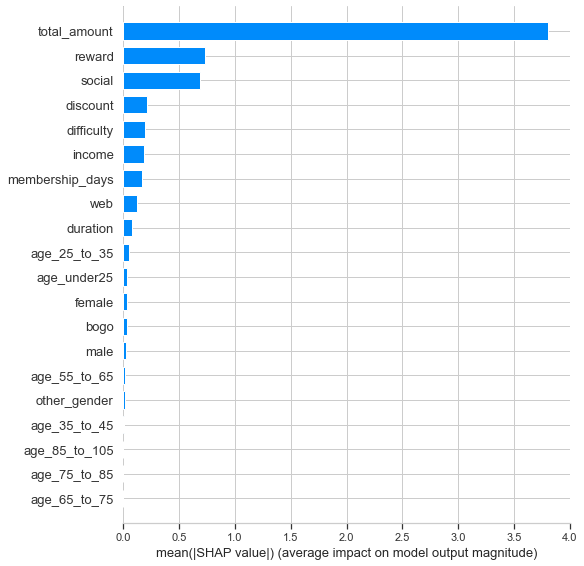

In [134]:
# take the mean absolute value of the SHAP values for each feature to get a standard bar plot
# this plot shows the same pattern as we got from the plot above
shap.summary_plot(shap_values_2, x_train, plot_type="bar")

In [135]:
# perform prediction on x_test data
y_pred_xgb = xgb.predict(x_test)

In [136]:
y_pred_xgb

array([1., 0., 1., ..., 1., 0., 1.])

In [137]:
evaluate(y_pred_xgb, y_test, verbose=True)

Confusion matrix: 
 [[9112  663]
 [1036 8760]]
Accuracy:   0.913

Recall:     0.930
Precision:  0.894
F2 score:   0.922



{'TP': 8760,
 'FP': 1036,
 'FN': 663,
 'TN': 9112,
 'Accuracy': 0.9131878800265699,
 'Precision': 0.8942425479787668,
 'Recall': 0.9296402419611589,
 'F2 score:': 0.9223382749326147}

### 2.3 Neural Networks

ref: book [Deep Learning with Python](https://learning.oreilly.com/library/view/deep-learning-with/9781617294433/).

#### Step 1 - Define a model

-- Our input data is matrics, and our labels are 1s and 0s. 
A type of network that performs well on such a problem would be a simple stack of fully-connected (`Dense`) layers with `relu` activations: `Dense(16, activation='relu')`

-- Such `Dense` layer with a `relu` activation implements 
the following chain of tensor operations:

`output = relu(dot(W, input) + b)`

-- A `relu` (rectified linear unit) is a function meant to zero-out negative values and produce something that can be interpreted as a probability [0~1].


In [116]:
# create a new model
nn_model = models.Sequential()

# add input and dense layer
# https://medium.com/@srnghn/deep-learning-overview-of-neurons-and-activation-functions-1d98286cf1e4
nn_model.add(layers.Dense(128, activation='relu', input_shape=(22,))) # 128 is the number of the hidden units
nn_model.add(layers.Dense(16, activation='relu'))
nn_model.add(layers.Dense(16, activation='relu'))

# add a final layer
nn_model.add(layers.Dense(1, activation='sigmoid'))
# In a binary classification problem (two output classes)
# our network should end with a Dense layer with 1 unit and a sigmoid activation
# because the output should be a scalar between 0 and 1, encoding a probability.

#### Step 2 - Pick a loss function & optimizer, and compile the model

Since we are facing a binary classification problem and the output of our network is a probability (we end our network with a single-unit layer with a sigmoid activation), it is best to use the `binary_crossentropy` loss. It isn't the only viable choice, we can also use, for instance, `mean_squared_error`. But crossentropy is usually the best choice when we are dealing with models that output probabilities. Crossentropy is a quantity from the field of Information Theory, that measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and our predictions.

In [117]:
# create a validation set by setting apart 9500 samples from the original training data 
# to validate our approach and monitor the accuracy of the model on data that it has never seen during training

x_val = x_train[:9500]
partial_x_train = x_train[9500:]
y_val = y_train[:9500]
partial_y_train = y_train[9500:]

In [121]:
# compile and train the model
nn_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = nn_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=128, # The batch size defines the number of samples that will be propagated through the network.
                    validation_data=(x_val, y_val))

Train on 36163 samples, validate on 9500 samples
Epoch 1/20
36163/36163 [==============================] - 0s 13us/step - loss: 0.2407 - acc: 0.9020 - val_loss: 0.2554 - val_acc: 0.8951
Epoch 2/20
36163/36163 [==============================] - 0s 9us/step - loss: 0.2389 - acc: 0.9024 - val_loss: 0.2331 - val_acc: 0.9073
Epoch 3/20
36163/36163 [==============================] - 0s 9us/step - loss: 0.2379 - acc: 0.9034 - val_loss: 0.3318 - val_acc: 0.8748
Epoch 4/20
36163/36163 [==============================] - 0s 9us/step - loss: 0.2358 - acc: 0.9046 - val_loss: 0.2599 - val_acc: 0.8928
Epoch 5/20
36163/36163 [==============================] - 0s 9us/step - loss: 0.2338 - acc: 0.9038 - val_loss: 0.2817 - val_acc: 0.8845
Epoch 6/20
36163/36163 [==============================] - 0s 9us/step - loss: 0.2349 - acc: 0.9043 - val_loss: 0.3025 - val_acc: 0.8715
Epoch 7/20
36163/36163 [==============================] - 0s 9us/step - loss: 0.2327 - acc: 0.9045 - val_loss: 0.2688 - val_acc: 0.889

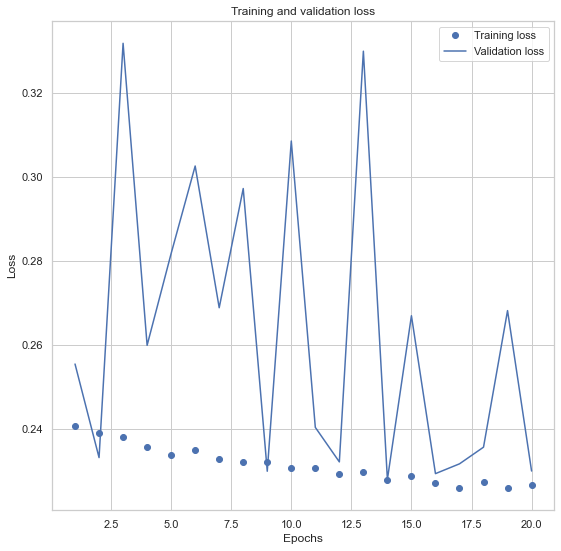

In [122]:
# plot training and validation loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')           
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')      
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

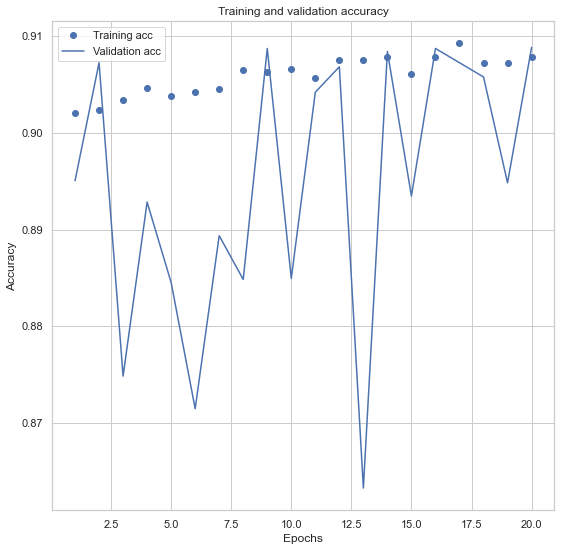

In [123]:
# plot training and validation loss

plt.clf()                                      
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

From the two figures above, the accuracy for validation dataset ranges from around 0.86 to 0.91, which is fairly stable and this result is quite good, this means the model is not overfitting, the reason I check this is because a model that performs better on the training data isn't necessarily a model that will do better on data it has never seen before. For an overfitting model, it will end up learning representations that are specific to the training data and do not generalize to data outside of the training set.

Next we retrain the model with the entire training dataset.

In [93]:
# retrain a new NN model for four epochs and see what happens
nn_model_2 = models.Sequential()
nn_model_2.add(layers.Dense(128, activation='relu', input_shape=(22,)))
nn_model_2.add(layers.Dense(16, activation='relu'))
nn_model_2.add(layers.Dense(16, activation='relu'))
nn_model_2.add(layers.Dense(1, activation='sigmoid'))

nn_model_2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

nn_model_2.fit(x_train, y_train, epochs=20, batch_size=128)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/20
45663/45663 [==============================] - 1s 11us/step - loss: 0.5422 - accuracy: 0.7204
Epoch 2/20
45663/45663 [==============================] - 0s 8us/step - loss: 0.4436 - accuracy: 0.7922
Epoch 3/20
45663/45663 [==============================] - 0s 8us/step - loss: 0.3769 - accuracy: 0.8440
Epoch 4/20
45663/45663 [==============================] - 0s 8us/step - loss: 0.3448 - accuracy: 0.8624
Epoch 5/20
45663/45663 [==============================] - 0s 8us/step - loss: 0.3207 - accuracy: 0.8732
Epoch 6/20
45663/45663 [==============================] - 0s 8us/step - loss: 0.3012 - accuracy: 0.8806
Epoch 7/20
45663/45663 [==============================] - 0s 9us/step - loss: 0.2861 - accuracy: 0.8868
Epoch 8/20
45663/45663 [==============================] - 0s 8us/step - loss: 0.2748 - accuracy: 0.8909
Epoch 9/20
45663/45663 [==============================] - 0s 8us/step - 

In [94]:
# predict on test dataset
y_pred_nn = nn_model_2.predict(x_test)
y_pred_nn

array([[0.763826  ],
       [0.07491139],
       [0.8373003 ],
       ...,
       [0.99605834],
       [0.00219638],
       [0.7634677 ]], dtype=float32)

In [138]:
# DeepExplainer ref: https://slundberg.github.io/shap/notebooks/deep_explainer/Keras%20LSTM%20for%20IMDB%20Sentiment%20Classification.html
# we use the first 100 training examples as our background dataset to integrate over
#background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]# we use the first 100 training examples as our background dataset to integrate over
#deep_explainer = shap.DeepExplainer(nn_model_2,  background)
deep_explainer = shap.DeepExplainer(nn_model_2, x_train[:100])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values_3 = deep_explainer.shap_values(x_train.values[:10])

In [139]:
shap.force_plot(deep_explainer.expected_value, shap_values_3[0][0,:], x_train.values[0,:])

In [140]:
shap.force_plot(deep_explainer.expected_value, shap_values_3[0][1,:], x_train.values[1,:])

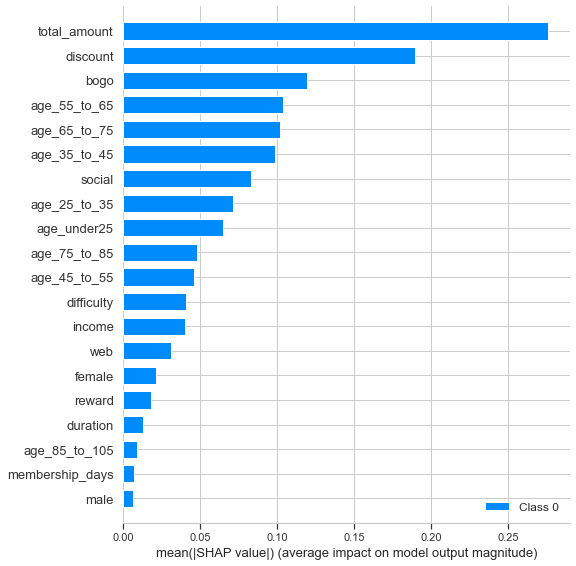

In [141]:
shap.summary_plot(shap_values_3, x_train)

In [142]:
y_pred_nn = (y_pred_nn > 0.5)
y_pred_nn

array([[ True],
       [False],
       [ True],
       ...,
       [ True],
       [False],
       [ True]])

In [143]:
evaluate(y_pred_nn, y_test, verbose=True)

Confusion matrix: 
 [[9172  812]
 [ 976 8611]]
Accuracy:   0.909

Recall:     0.914
Precision:  0.898
F2 score:   0.911



{'TP': 8611,
 'FP': 976,
 'FN': 812,
 'TN': 9172,
 'Accuracy': 0.9086403351898217,
 'Precision': 0.8981954730364035,
 'Recall': 0.9138278679825957,
 'F2 score:': 0.9106580088411345}

<div align="center"><b>Final scores comparison</b></div>

| Model | Accuracy | Precision | Recall | F2 Score | TP | FP | TN | FN |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| Logistic Regression (baseline) |0.85371 | 0.87121 | 0.81694 | 0.82724 | 7698 | 1138 | 9010 | 1725|
| XGBoost | 0.91319 | 0.89424 | 0.92964 | 0.92234 | 8760 | 1036 | 9112 | 663|
| Neural Network | 0.90864 | 0.89820 | 0.91383 | 0.91066 | 8611 | 976 | 9172 | 812 |